In [3]:
from mars.embeddings import *
import numpy as np
from tqdm import tqdm
from mars import db  # !python -m spacy download en_core_web_sm
import pandas as pd
import plotly.express
import seaborn
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline


def get_top_n_indexes(l, n):
    top_n_idx = np.argsort(l)[-n:]
    return top_n_idx


os.chdir("../..")

2021-08-18 17:16:44.328350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-18 17:16:44.328404: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-18 17:16:44.328425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-8E43FDR): /proc/driver/nvidia/version does not exist
2021-08-18 17:16:44.328703: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-18 17:16:46.778355: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLI

ModuleNotFoundError: No module named 'plotly'

In [ ]:
from mars.target_embeddings import *

In [40]:
target_embbedings = get_sentence_to_embedding_mapping(targets)

In [54]:
df_labels = pd.read_csv('data/labels.csv', index_col=0)

In [33]:
processed_texts = db.collections.processed_texts
search_targets = db.collections.search_targets

In [36]:
## Adding filename to processed texts
# TODO: 
for doc in tqdm(db.collections.document_sources.fetchAll()):
    filename = doc["url"].split("/")[-1]
    text_id = db.collections.contents.fetchFirstExample({"source_doc_id": doc["_id"]})[
        0
    ]["_id"]
    p_text = processed_texts.fetchFirstExample({"textId": text_id})[0]
    p_text["filename"] = filename
    p_text.save()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:57<00:00,  7.36s/it]


In [42]:
from collections import defaultdict

all_similarities = defaultdict(dict)

for text in tqdm(processed_texts.fetchAll()):
    for target_sentence, target_embedding in target_embbedings.items():
        try:
#             target_embedding = np.array(search_target["embedding"])
#             target_name = target["sentence"]
            scores = list(np.matmul(
                np.array(text["sentencesEmbeddings"]), np.transpose(target_embedding)
            ))
            
            all_similarities[text["filename"]][target_sentence] = scores
        except Exception as e:
            print(e)

 38%|██████████████████████████████████▏                                                        | 6/16 [00:01<00:02,  4.13it/s]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requ

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


In [45]:
all_similarities = dict(all_similarities)

In [46]:
df = pd.DataFrame(dict(all_similarities))

In [64]:
df_labels = df_labels[df.columns]

In [65]:
#seaborn.heatmap(df,annot=True,cmap="YlGnBu",cbar=False)

In [74]:
df.apply?

In [81]:
document_names = df_labels.columns

In [120]:
X = df[document_names].values.flatten()
y = df_labels[document_names].values.flatten()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [129]:
X_max = list(map(max, X_test))

### Baseline

In [202]:
def evaluate(y_pred, y):
    bc = plot_metric.functions.BinaryClassification(
        y, y_pred, labels=["Class 1", "Class 2"]
    )
    bc.plot_roc_curve()
    print("AUC ROC:", sklearn.metrics.roc_auc_score(y, y_pred))

AUC ROC: 0.6167247386759582


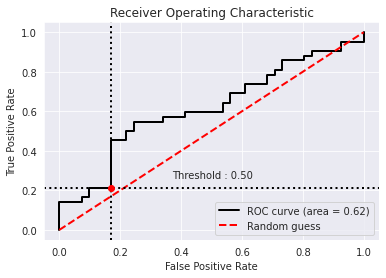

In [203]:
evaluate(X_max, y_test)

In [308]:
def get_bucketizer(bins):
    def bucketize_scores(scores):
        return np.stack([np.histogram(x, range=(-1, 1), bins=bins)[0] for x in scores])
    return bucketize_scores

In [474]:
def bucketize(scores, bins):
    return np.stack([np.histogram(x, range=(-1, 1), bins=bins)[0] for x in scores])

In [313]:
X_train.shape

(247,)

In [316]:
# FunctionTransformer(get_bucketizer(250), validate=False).fit_transform(X_train)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [400]:
from sklearn.feature_selection import RFE,RFECV

In [475]:
buckets_num = 250

model = make_pipeline(
    FunctionTransformer(bucketize, validate=False, kw_args={'bins':50}),
    VarianceThreshold(threshold=0),
    RFECV((LogisticRegression(penalty="l1", solver="liblinear")), step=1, cv=3),
    LogisticRegression(solver="liblinear"),
)
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function bucketize at 0x7fda7be73ea0>, inv_kw_args=None,
          inverse_func=None, kw_args={'bins': 50}, pass_y='deprecated',
          validate=False)), ('variancethreshold', VarianceThres...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [476]:
sum(model.steps[-2][1].get_support())

9

AUC ROC: 0.6141732283464567


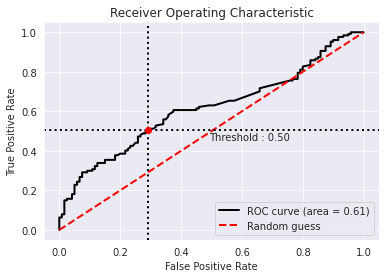

In [477]:
y_pred = model.predict_proba(X_train)[:, 1]
evaluate(y_pred, y_train)

AUC ROC: 0.45499419279907083


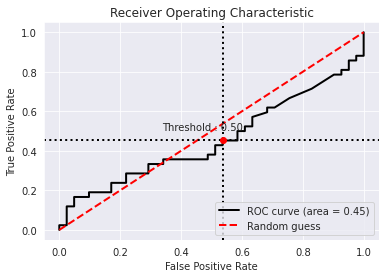

In [478]:
y_pred = model.predict_proba(X_test)[:, 1]
evaluate(y_pred, y_test)

In [479]:
buckets_num = 250

model = make_pipeline(
    FunctionTransformer(bucketize, validate=False, kw_args={"bins": buckets_num}),
    VarianceThreshold(threshold=0),
    RFE(
        (LogisticRegression(penalty="l1", solver="liblinear")),
        step=1,
        n_features_to_select=50,
    ),
    LogisticRegression(solver="liblinear"),
)
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function bucketize at 0x7fda7be73ea0>, inv_kw_args=None,
          inverse_func=None, kw_args={'bins': 250}, pass_y='deprecated',
          validate=False)), ('variancethreshold', VarianceThre...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [421]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'functiontransformer', 'variancethreshold', 'rfe', 'logisticregression', 'functiontransformer__accept_sparse', 'functiontransformer__check_inverse', 'functiontransformer__func', 'functiontransformer__inv_kw_args', 'functiontransformer__inverse_func', 'functiontransformer__kw_args', 'functiontransformer__pass_y', 'functiontransformer__validate', 'variancethreshold__threshold', 'rfe__estimator__C', 'rfe__estimator__class_weight', 'rfe__estimator__dual', 'rfe__estimator__fit_intercept', 'rfe__estimator__intercept_scaling', 'rfe__estimator__max_iter', 'rfe__estimator__multi_class', 'rfe__estimator__n_jobs', 'rfe__estimator__penalty', 'rfe__estimator__random_state', 'rfe__estimator__solver', 'rfe__estimator__tol', 'rfe__estimator__verbose', 'rfe__estimator__warm_start', 'rfe__estimator', 'rfe__n_features_to_select', 'rfe__step', 'rfe__verbose', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_inte

In [481]:
param_grid = {
    "rfe__n_features_to_select": list(range(10,101,5)),
    "functiontransformer__kw_args":[{"bins":int(n)} for n in np.linspace(10,400,num=40)]
}

In [490]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


cv = GridSearchCV(model, param_grid, scoring="roc_auc",n_jobs=-1, verbose=1)

In [491]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 760 candidates, totalling 2280 fits


/home/stanislaw/repos/AI-stretegies-papers-regulations-monitoring/.venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed: 33.5min finished
/home/stanislaw/repos/AI-stretegies-papers-regulations-monitoring/.venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:842: De

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function bucketize at 0x7fda7be73ea0>, inv_kw_args=None,
          inverse_func=None, kw_args={'bins': 250}, pass_y='deprecated',
          validate=False)), ('variancethreshold', VarianceThre...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rfe__n_features_to_select': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'functiontransformer__kw_args': [{'bins': 10}, {'bins': 20}, {'bins': 30}, {'bins': 40}, {'bins': 50}, {'bins': 60}, {'bins': 70}, {'bins': 80}, {'bins': 90}, {'bins': 100}, {'bins...s': 340}, {'bins': 350}, {'bins': 360}, {'bins': 370}, {'bins': 380}, {'bins': 390}, {'bins': 400}]},
       pre_dispatch='2*n_jobs', re

In [492]:
cv.best_params_

{'functiontransformer__kw_args': {'bins': 310},
 'rfe__n_features_to_select': 50}

In [493]:
cv.best_score_

0.7131079039279774

In [498]:
model = cv.best_estimator_

AUC ROC: 0.9543963254593176


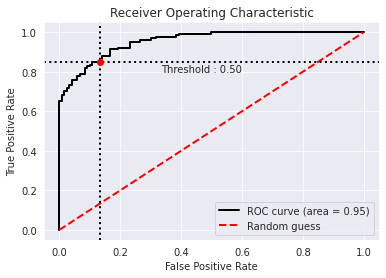

In [499]:
y_pred = model.predict_proba(X_train)[:, 1]
evaluate(y_pred, y_train)

AUC ROC: 0.6001742160278746


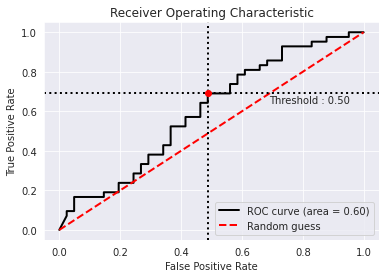

In [500]:
y_pred = model.predict_proba(X_test)[:, 1]
evaluate(y_pred, y_test)

In [495]:
import joblib

In [501]:
joblib.dump(cv.best_estimator_, "model.pkl")

PermissionError: [Errno 13] Permission denied: 'model.pkl'

In [418]:
sum(model.steps[-2][1].get_support())

50

AUC ROC: 0.8737532808398951


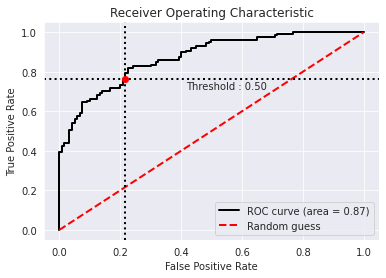

In [419]:
y_pred = model.predict_proba(X_train)[:, 1]
evaluate(y_pred, y_train)

AUC ROC: 0.575493612078978


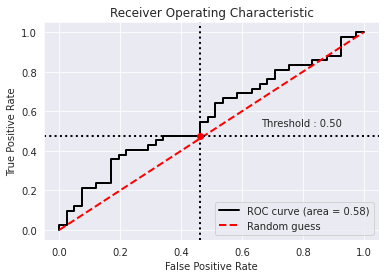

In [420]:
y_pred = model.predict_proba(X_test)[:, 1]
evaluate(y_pred, y_test)

# Laser

In [502]:
import mars.embeddings

In [ ]:
mars.embeddings.